In [1]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
from qcqp import *
import cvxpy as cp

In [3]:
def empty_graph(n=0,create_using=None):
    if create_using is None:
        # default empty graph is a simple graph
        G=nx.Graph()
    else:
        G=create_using
        G.clear()

    G.add_nodes_from(range(n))
    G.name="empty_graph(%d)"%n
    return G

def complete_graph(n, weight, create_using=nx.DiGraph()):
    """ Return the complete graph K_n with n nodes.

    Node labels are the integers 0 to n-1.
    """
    G=empty_graph(n,create_using)
    G.name="complete_graph(%d)"%(n)
    if n>1:
        if G.is_directed():
            edges=itertools.permutations(range(n),2)
        else:
            edges=itertools.combinations(range(n),2)
        G.add_weighted_edges_from((u,v,weight) for u,v in edges)
        #G.add_edges_from(edges)
    return G

def scale_free_graph(N, alpha, beta, gamma):
    G = nx.scale_free_graph(N, alpha, beta, gamma)
    edges = []
    A = nx.adjacency_matrix(G).todense()
    G2 = nx.from_numpy_matrix(A, create_using = nx.DiGraph())
    return G2
    
    
def draw(G):
    #The positions of each node are stored in a dictionary
    pos=nx.spring_layout(G)
    # The edge weights of each arcs are stored in a dictionary
    arc_weight=nx.get_edge_attributes(G,'weight')
    #print(arc_weight)
    # Draw the nodes
    nx.draw_networkx(G, pos, node_size=450)
    # Draw the node labels
    # nx.draw_networkx_labels(G1, node_pos,node_color= node_col)
    # Draw the edges
    nx.draw_networkx_edges(G, pos)
    # Draw the edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=arc_weight)
    # Remove the axis
    plt.axis('off')
    # Show the plot
    plt.show()
    
def set_weights(G):
    # get the edge weight from a power law dist
    N = len(list(G.edges))
    z = nx.utils.powerlaw_sequence(N, exponent=2)
    # round to integer values in the range [0,n]
    zseq = [min(N, max(int(round(s)), 0)) for s in z]

    i = 0
    for e in G.edges:
        #if len(e)==2:
        G[e[0]][e[1]]['weight'] = zseq[i]
        i = i+1

    plt.hist(z)
    plt.show()

In [166]:
def adjacency(G):
    A = nx.adjacency_matrix(G, weight='weight')
    A = A.todense()
    A = np.asarray(A).reshape(-1)
    return A

def get_param(A, C_attack, C_defense):
    # flow vectors
    f = A
    f_diag = np.diag(f)
    
    s = f_diag.shape
    zero_matrix = np.zeros(s)

    P_0_1 = np.concatenate((zero_matrix, f_diag, zero_matrix), axis=1)
    P_0_2 = np.concatenate((f_diag, zero_matrix, zero_matrix), axis=1)
    P_0_3 = np.concatenate((zero_matrix, zero_matrix, zero_matrix), axis=1)

    P_0 = -1/2 * np.concatenate((P_0_1, P_0_2, P_0_3))
    
    P_u_1 = np.concatenate((zero_matrix, f_diag, -f_diag), axis=1)
    P_u_2 = np.concatenate((f_diag, zero_matrix, zero_matrix), axis=1)
    P_u_3 = np.concatenate((-f_diag, zero_matrix, zero_matrix), axis=1)

    P_u = 1/2 * np.concatenate((P_u_1, P_u_2, P_u_3))
    
    P_f1 = P_f2 = P_f3 = np.zeros(P_0.shape)

    P_geq = np.zeros(P_0.shape)
    P_leq = np.zeros(P_0.shape)
    
    r_0 = r_u = 0

    r_f1 = -C_defense
    r_f2 = -C_attack
    r_f3 = -C_attack
    
    t = f.shape
    zero_vec = np.zeros(t)

    q_0 = np.concatenate((zero_vec, zero_vec, zero_vec))
    q_u = np.concatenate((zero_vec, -f, f))
    
    q_f1 = np.concatenate((f, zero_vec, zero_vec))
    q_f2 = np.concatenate((zero_vec, f, zero_vec))
    q_f3 = np.concatenate((zero_vec, zero_vec, f))
    
    return P_0, q_0, r_0, P_u, q_u, r_u, q_f1, q_f2, q_f3, r_f1, r_f2, r_f3

class my_qcqp(QCQP):
    def __init__(self, prob):
        super().__init__(prob)
        
        
    def my_suggest(self, method=qcqp.s.RANDOM, eps=1e-8, *args, **kwargs):
        if method not in qcqp.s.suggest_methods:
            raise Exception("Unknown suggest method: %s\n", method)
        if method == qcqp.s.RANDOM:
            x = np.random.randn(self.n)
        elif method == qcqp.s.SPECTRAL:
            if self.spectral_sol is None:
                self.spectral_sol, self.spectral_bound = solve_spectral(self.qcqp_form, *args, **kwargs)
                if self.maximize_flag:
                    self.spectral_bound *= -1
            x = self.spectral_sol
        elif method == qcqp.s.SDR:
            if self.sdr_sol is None:
                self.sdr_sol, self.sdr_bound = qcqp.solve_sdr(self.qcqp_form, *args, **kwargs)
                if self.maximize_flag:
                    self.sdr_bound *= -1
                self.mu = np.asarray(self.sdr_sol[:-1, -1]).flatten()
                self.Sigma = self.sdr_sol[:-1, :-1] - self.mu*self.mu.T + eps*qcqp.sp.identity(self.n)
            np.random.seed(7)
            x = np.random.multivariate_normal(self.mu, self.Sigma)
        
        qcqp.assign_vars(self.prob.variables(), x)
        f0 = self.qcqp_form.f0.eval(x)
        if self.maximize_flag: f0 *= -1
        return (f0, max(self.qcqp_form.violations(x)), self.mu, self.Sigma)
        
def stackelberg_qcqp(A, C_attack, C_defense):
    P_0, q_0, r_0, P_u, q_u, r_u, q_f1, q_f2, q_f3, r_f1, r_f2, r_f3 = get_param(A, C_attack, C_defense)

    # Form a nonconvex problem
    x = cp.Variable(q_0.shape[0], )
    objective = x.T @ P_0 @ x + q_0.T @ x + r_0
    constraints = [x.T @ P_0 @ x + q_0.T @ x + r_0 >=  -C_defense, 
        cp.quad_form(x, P_u) + q_u.T @ x + r_u <= 0, # attacker constraint
                   q_f1.T @ x + r_f1 <= 0,
                   q_f2.T @ x + r_f2 <= 0,
                   q_f3.T @ x + r_f3 <= 0,
                   x <= 1,
                  x >= 0,
                   x[np.tile(np.equal(A, 0), 3)] == 0 # 
                  ]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    # Create a QCQP handler.
    #qcqp = QCQP(prob)
    
    my_qcqp_obj = my_qcqp(prob)
    
    # Solve the SDP relaxation and get a starting point to a local method
    f_cd, v_cd, mu, sigma = my_qcqp_obj.my_suggest(SDR)
    
    #print("SDR lower bound: %.3f" % sdr_bound)
    '''
    Both improve() and suggest() methods return a pair (f, v),
    where f represents the current objective value, 
    and v represents the maximum constraint violation of the current point.
    '''

    return x, prob, qcqp, f_cd, v_cd, mu, sigma

def round(sol, A, C_attack, C_defense):
    v = np.asarray(sol).reshape(np.size(sol),1)
    P_0, q_0, r_0, P_u, q_u, r_u, q_f1, q_f2, q_f3, r_f1, r_f2, r_f3 = get_param(A, C_attack, C_defense)
    
    slice_index = A.shape[0]

    y_ind_1, y_ind_2 = 0, slice_index
    x_star_ind_1, x_star_ind_2 = slice_index,slice_index*2
    x_ind_1, x_ind_2 = slice_index*2,slice_index*3

    if (v[x_ind_1: x_ind_2] != v[x_star_ind_1: x_star_ind_2]).any():
        v[x_ind_1: x_ind_2] = v[x_star_ind_1: x_star_ind_2]

    have_edge = np.tile(~np.equal(A,0),3).reshape(np.size(v),1)

    v[(v>1)*(have_edge)]=1
    v[(v<0)*(have_edge)]=0
    v[(~have_edge)]=0


    if np.dot(q_f1, v) + r_f1 > 0:
        #print("Violated y capacity constraint ")
        v[y_ind_1:y_ind_2] = v[y_ind_1:y_ind_2] * C_defence/np.dot(A,v[y_ind_1:y_ind_2])

    if np.dot(q_f2, v) + r_f2 > 0:
        #print("Violated x_star capacity constraint ")
        v[x_star_ind_1: x_star_ind_2] = v[x_star_ind_1: x_star_ind_2] * C_attack/np.dot(A,v[x_star_ind_1: x_star_ind_2])

    if np.dot(q_f3, v) + r_f3 > 0:
        #print("Violated x capacity constraint ")
        v[x_ind_1: x_ind_2] = v[x_ind_1: x_ind_2] * C_attack/np.dot(A,v[x_ind_1: x_ind_2])

    
    objective = np.matmul(v.T, np.matmul(P_0,v)) + np.dot(q_0, v) + r_0
    
    return objective[0][0], v

def stackelberg_qcqp_round(L, A, C_attack, C_defense):
    sol_obj_list = []
    sol_v_list = []
    
    # get the output of SDR suggest method
    sol, prob, qcqp, f_cd, v_cd, mu, sigma = stackelberg_qcqp(A, C_attack, C_defence)
    objective, v = round(sol.value, A, C_attack, C_defense)
        
    sol_obj_list.append(objective)
    sol_v_list.append(v)
    
    for i in range(L-1):
         
        # sample from mu, sigma computed through SDR suggest
        x = np.random.multivariate_normal(mu, sigma)
        
        objective, v = round(x, A, C_attack, C_defense)
        
        sol_obj_list.append(objective)
        sol_v_list.append(v)
        
    
    min_ind = np.argmin(sol_obj_list)
        
    return sol_obj_list[min_ind], sol_v_list[min_ind], sol_obj_list, sol_v_list

def stackelberg_qcqp_improve(sol, A, C_attack, C_defense):
    sol, prob, qcqp, f_cd, v_cd = stackelberg_qcqp(A, C_attack, C_defence)
    # Attempt to improve the starting point given by the suggest method
    print("Optimizing...")
    f_cd, v_cd = qcqp.improve(COORD_DESCENT)
    print("Coordinate descent: objective %.3f, violation %.3f" % (f_cd, v_cd))
    print(np.round(sol.value,4))
    
    return f_cd, v_cd
    

### create a complete digraph 

No. of nodes: 10
No. of edges: 90


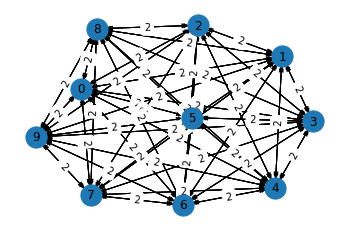

In [5]:
num_of_nodes = 10
weight = 2
G1 = complete_graph(num_of_nodes, weight)
print("No. of nodes:", len(list(G1.nodes)))
print("No. of edges:", len(list(G1.edges)))

draw(G1)

In [8]:
A = adjacency(G1)

# Choose C_attack greater than C_defense
C_attack = 12
C_defence = 10

x, prob, qcqp = stackelberg_qcqp(A, C_attack, C_defence)

Optimizing...
Coordinate descent: objective -0.386, violation 0.031
[[-0.000e+00]
 [-1.570e-02]
 [-8.000e-04]
 [ 2.170e-02]
 [ 1.660e-01]
 [ 5.000e-03]
 [ 5.445e-01]
 [ 1.500e-03]
 [-5.300e-03]
 [ 4.750e-02]
 [ 1.000e-04]
 [ 0.000e+00]
 [ 7.240e-02]
 [ 4.220e-02]
 [-3.000e-03]
 [ 5.086e-01]
 [ 1.200e-03]
 [ 3.590e-02]
 [ 1.210e-02]
 [ 3.700e-03]
 [ 1.220e-02]
 [ 2.640e-02]
 [-0.000e+00]
 [ 2.600e-03]
 [-6.500e-03]
 [ 8.240e-02]
 [ 9.600e-03]
 [ 6.450e-02]
 [ 1.271e-01]
 [ 1.410e-02]
 [ 1.800e-03]
 [-1.900e-03]
 [ 3.800e-03]
 [-0.000e+00]
 [ 7.890e-02]
 [ 3.800e-03]
 [ 2.053e-01]
 [ 2.013e-01]
 [ 7.340e-02]
 [ 1.716e-01]
 [ 1.380e-02]
 [ 2.330e-02]
 [ 7.010e-02]
 [ 3.400e-03]
 [-0.000e+00]
 [ 4.875e-01]
 [ 6.000e-04]
 [ 4.940e-02]
 [ 6.700e-03]
 [ 3.000e-04]
 [-1.000e-02]
 [ 1.472e-01]
 [ 6.950e-02]
 [ 2.600e-03]
 [ 3.340e-02]
 [ 0.000e+00]
 [ 2.000e-04]
 [ 1.129e-01]
 [ 8.800e-03]
 [ 6.950e-02]
 [ 3.740e-02]
 [ 5.900e-03]
 [ 4.680e-02]
 [ 1.460e-02]
 [ 3.200e-03]
 [-2.500e-03]
 [ 0.000

In [ ]:
A = adjacency(G1)

# Choose C_attack greater than C_defense
C_attack = 30
C_defence = 20

x, prob, qcqp = stackelberg_qcqp(A, C_attack, C_defence)

### Create scale free graph with power law flows

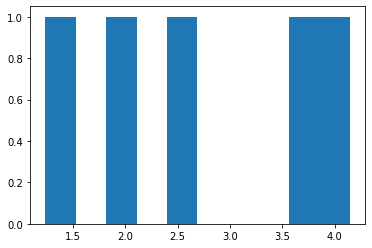

No. of nodes: 5
No. of edges: 5


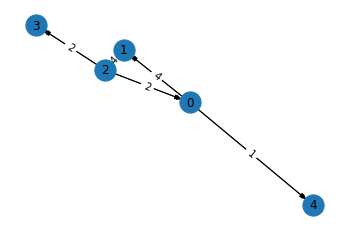

In [6]:
G2 = scale_free_graph(5, alpha=0.1, beta=0.1, gamma=0.8)
set_weights(G2)
print("No. of nodes:", len(list(G2.nodes)))
print("No. of edges:", len(list(G2.edges)))

draw(G2)

In [ ]:
A = adjacency(G2)

C_attack = 5
C_defence = 4

x, prob, qcqp = stackelberg_qcqp(A, C_attack, C_defence)

### small graph

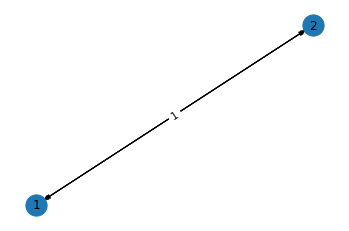

In [7]:
graph = nx.DiGraph()
graph.add_node(1)

graph.add_edges_from([(1,2)], weight=1)
graph.add_edges_from([(2,1)], weight=1)
#The positions of each node are stored in a dictionary
pos=nx.spring_layout(graph)
# The edge weights of each arcs are stored in a dictionary
arc_weight=nx.get_edge_attributes(graph,'weight')

# Draw the nodes 
draw(graph)

In [169]:
G = graph
A = adjacency(G)

C_attack = 1
C_defense = 2

# L = 10
# objective, v, obj_list, v_list = stackelberg_qcqp_round(L, A, C_attack, C_defense)

L_list = [1,5,20,50,100,200]

objective_res_list = np.zeros_like(L_list) 

for i in range(len(L_list)):
    objective_res_list[i], _, _, _ = stackelberg_qcqp_round(L_list[i], A, C_attack, C_defense)
    
print("Objective:", objective_res_list)

#f_cd, v_cd = stackelberg_qcqp_improve(sol, A, C_attack, C_defense)

/anaconda3/envs/fraud_game/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: covariance is not positive-semidefinite.
/anaconda3/envs/fraud_game/lib/python3.6/site-packages/ipykernel_launcher.py:165: RuntimeWarning: covariance is not positive-semidefinite.


Objective: [-1 -1 -1 -1 -1 -1]


## Example problems

In [ ]:
# Solves a bounded least-squares problem.
import numpy

# Problem data.
m = 10
n = 5
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

In [80]:
from numpy.random import randn
import cvxpy as cvx
from qcqp import *

n, m = 10, 15
A = randn(m, n)
b = randn(m, 1)

# Form a nonconvex problem.
x = cvx.Variable(n)
obj = cvx.sum_squares(A*x - b)
cons = [cvx.square(x) == 1]
prob = cvx.Problem(cvx.Minimize(obj), cons)

# Create a QCQP handler.
qcqp = QCQP(prob)

# Solve the SDP relaxation and get a starting point to a local method
qcqp.suggest(SDR)
print("SDR lower bound: %.3f" % qcqp.sdr_bound)

# Attempt to improve the starting point given by the suggest method
f_cd, v_cd = qcqp.improve(COORD_DESCENT)
print("Coordinate descent: objective %.3f, violation %.3f" % (f_cd, v_cd))
print(x.value)

SDR lower bound: 24.805
Coordinate descent: objective 38.146, violation 0.000
[[ 1.00001187]
 [ 1.00003556]
 [ 0.9999628 ]
 [ 1.00000027]
 [-0.99998397]
 [-1.00001147]
 [ 0.9999628 ]
 [ 1.00000901]
 [ 0.99999871]
 [-1.00003072]]


In [85]:
print(prob.value)

None
